In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# -------- range of the variables ----------
V_S = 7.0                   # service speed [kn]
range_D     = [0.5, 0.8]
range_AEdAO = [0.3, 1.05]
range_PdD   = [0.5, 1.4]
range_Z     = [2, 7]

# Define the lower and upper bounds for each variable
lower_bounds = [range_D[0], range_AEdAO[0], range_PdD[0]]
upper_bounds = [range_D[1], range_AEdAO[1], range_PdD[1]]

Load files

In [3]:
# path to the run, with VS speed as dir names, containing the csv for each Z
dir_path = '../Main/run/'

In [4]:
from typing import NamedTuple

class resultZ(NamedTuple):
    D:     float
    AEdAO: float
    PdD:   float
    Z:     int
    fitness: float
    history: list
    valid: bool
    
# r = resultZ(.5, .6, .7, 2, -150, [10,11,12,13], True)
# r.D

In [5]:
import csv
from os import chdir, listdir


col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
def get_data_from_z_file(path, filename):
    df = pd.read_csv(path+'/'+filename, header=None, skiprows=1, names=col_names)
    
    # penalty and valid were not saved in this test, so need to be created
    df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
    df['valid'] = (df['penalty'] == 0)
    
    # the best value (saved in the last row)
    D, AEdAO, PdD, Z, fitness = df.iloc[-1][['D', 'AEdAO', 'PdD', 'Z', 'fitness']]
    Z = int(Z)
    # history (the best fitness found at each iteration)
    history = df.loc[df['D'] == 'fitness at iteration']['fitness'].to_numpy()
    # valid
    valid = df.loc[(df['D'] == D) & (df['AEdAO'] == AEdAO) & (df['PdD'] == PdD) & (df['n'] == 0)]['valid'].values[0]
    
    # create resultZ
    r = resultZ(D, AEdAO, PdD, Z, fitness, history, valid)
    return r

def load_results_z(vs_dir):
    results_all = {'cmaes': [], 'openaies': []}
    for dir_seed_run in listdir(vs_dir):
#         file_dir = vs_dir +'/'+ dir_seed_run
        # cmaes
        run_dict_cmaes = {}
        file_dir = vs_dir +'/'+ dir_seed_run + '/cmaes'
        for filename_z in listdir(file_dir):
            r = get_data_from_z_file(file_dir, filename_z)
            run_dict_cmaes[r.Z] = r
        results_all['cmaes'].append(run_dict_cmaes)
#         # openaies
        run_dict_openaies = {}
        file_dir = vs_dir +'/'+ dir_seed_run + '/openaies'
        for filename_z in listdir(file_dir):
            r = get_data_from_z_file(file_dir, filename_z)
            run_dict_openaies[r.Z] = r
        results_all['openaies'].append(run_dict_openaies)
    return results_all

In [6]:
VS = '7_0'
vs_dir = dir_path + VS

results_temp = load_results_z(vs_dir)

Compare

In [7]:
results_temp['cmaes'][0]

{3: resultZ(D='0.7999925569360042', AEdAO=0.5520503611625983, PdD=0.5666919571151037, Z=3, fitness=-83.40590873824594, history=array([-95.32890925, -89.64947438, -88.70678524, -88.70678524,
        -87.57903121, -86.24623559, -85.79297229, -85.79297229,
        -83.75597889, -83.75597889, -83.75597889, -83.75597889,
        -83.75597889, -83.67472749, -83.60611577, -83.57596295,
        -83.47401781, -83.45698054, -83.45698054, -83.45698054,
        -83.45698054, -83.45698054, -83.44946507, -83.40590874,
        -83.40590874, -83.40590874, -83.40590874, -83.40590874,
        -83.40590874, -83.40590874]), valid=True),
 7: resultZ(D='0.799996636152729', AEdAO=0.7236421116293007, PdD=0.7775819369446101, Z=7, fitness=-82.95422111580872, history=array([-93.15174215, -86.1718689 , -84.41534964, -84.41534964,
        -84.41534964, -84.41534964, -83.59008768, -83.59008768,
        -83.59008768, -83.59008768, -83.59008768, -83.16944761,
        -83.16944761, -83.16944761, -83.12514528, -83.0498

In [8]:
print("Best fitness")

solvers_results = {}

for solver in results_temp:
    results_fit = [max([results_z_dict[z].fitness for z in results_z_dict]) for results_z_dict in results_temp[solver]]
    if len(results_fit) > 0: # there is results for this solver
        solvers_results[solver] = results_fit
        print(max(results_fit), '\t', solver)

Best fitness
-81.4056436122919 	 cmaes
-81.42197498870249 	 openaies


In [9]:
print("Valid results found")

for solver in results_temp:
    results = [[results_z_dict[z].valid for z in results_z_dict] for results_z_dict in results_temp[solver]]
    valid_count = 0
    total_count = 0
    for r in results:
        valid_count += sum(r)
        total_count += len(r)
    print(valid_count, 'of', total_count, '\t', solver)

Valid results found
56 of 60 	 cmaes
58 of 60 	 openaies


## Grafics

In [10]:
solvers_colors = {'openaies': 'blue',
                  'cmaes':    'orange'}

labels =[solver for solver in solvers_results]

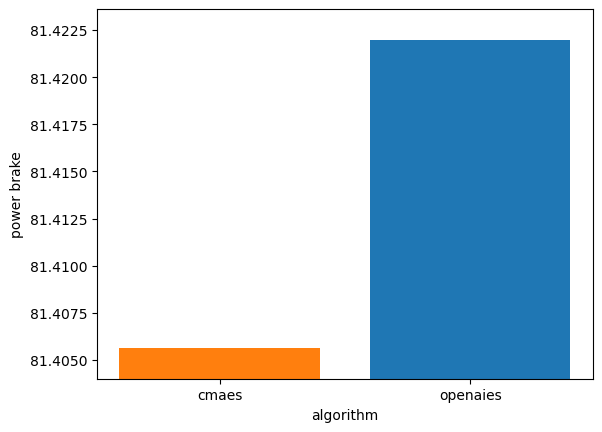

In [11]:
fig, ax = plt.subplots()


counts = [-max(solvers_results[solver]) for solver in solvers_results]
bar_colors = ['tab:'+solvers_colors[solver] for solver in solvers_results]

ax.bar(labels, counts , color=bar_colors)

ax.set_ylabel('power brake')
ax.set_xlabel('algorithm')

dif = abs(min(counts) - max(counts)) / 10
plt.ylim([min(counts)-dif, max(counts)+dif])

plt.show()


/tmp/ipykernel_3976/2790390856.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['cmaes', 'openaies'])


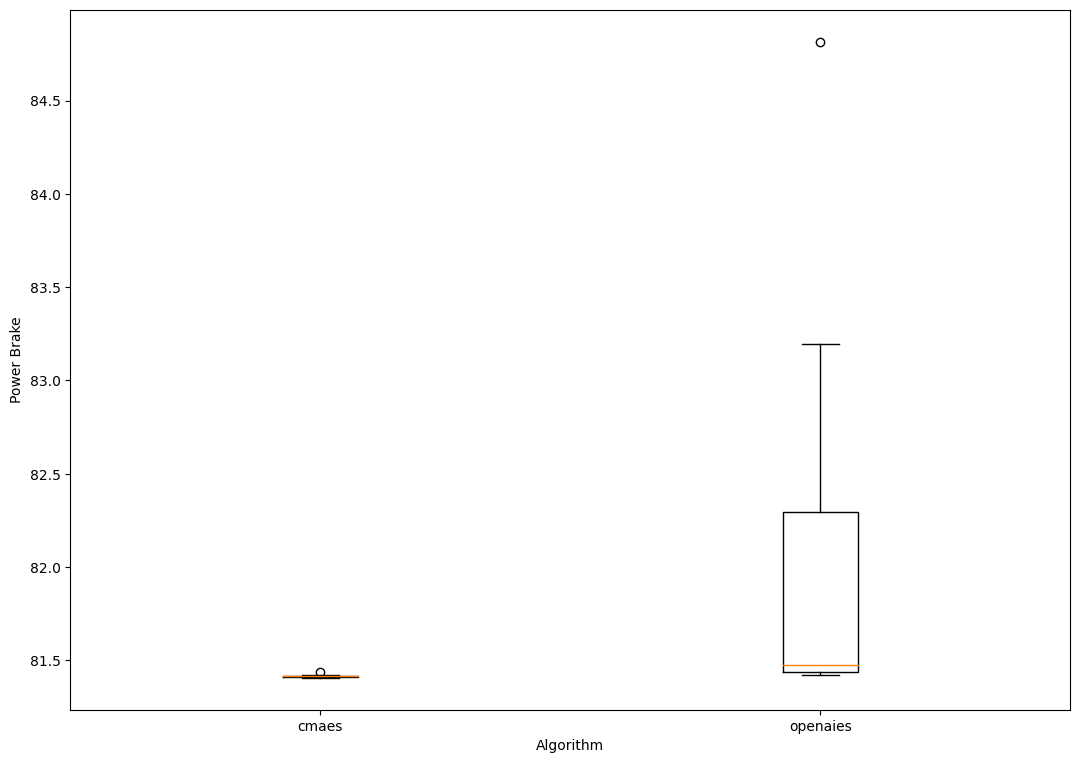

In [12]:
def get_array_fitness(results_list):
    return [-results[2] for results in results_list]

data = [np.negative(solvers_results[solver]) for solver in solvers_results]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xticklabels(['cmaes', 'openaies'])


ax.set(
#     title='Comparison of the best results for minimal power brake',
    xlabel='Algorithm',
    ylabel='Power Brake',
)

# Creating plot
bp = ax.boxplot(data)

# ALL DATA

In [13]:
results_by_vs = {}
for VS in sorted(listdir(dir_path)):
    results_by_vs[VS] = load_results_z(dir_path+'/'+VS)
    print('loaded', VS)

loaded 7_0
loaded 7_5
loaded 8_0
loaded 8_5


In [14]:
results_by_vs

{'7_0': {'cmaes': [{3: resultZ(D='0.7999925569360042', AEdAO=0.5520503611625983, PdD=0.5666919571151037, Z=3, fitness=-83.40590873824594, history=array([-95.32890925, -89.64947438, -88.70678524, -88.70678524,
           -87.57903121, -86.24623559, -85.79297229, -85.79297229,
           -83.75597889, -83.75597889, -83.75597889, -83.75597889,
           -83.75597889, -83.67472749, -83.60611577, -83.57596295,
           -83.47401781, -83.45698054, -83.45698054, -83.45698054,
           -83.45698054, -83.45698054, -83.44946507, -83.40590874,
           -83.40590874, -83.40590874, -83.40590874, -83.40590874,
           -83.40590874, -83.40590874]), valid=True),
    7: resultZ(D='0.799996636152729', AEdAO=0.7236421116293007, PdD=0.7775819369446101, Z=7, fitness=-82.95422111580872, history=array([-93.15174215, -86.1718689 , -84.41534964, -84.41534964,
           -84.41534964, -84.41534964, -83.59008768, -83.59008768,
           -83.59008768, -83.59008768, -83.59008768, -83.16944761,
         

More stuff

In [15]:
for vs in results_by_vs:
    for solver in results_by_vs[vs]:
        print(vs, solver)
        results_vs_solver = results_by_vs[vs][solver]
        # create metrics
        fitness_all = [] # from all the results
        fitness_run = [] # best fitness found for each run (between the Z [2,7])
        fitness = {}
        valids  = {}
        totals  = {}
        for z in range(2,8):
            valids[z] = 0
            totals[z] = 0
            fitness[z] = []
        # update metrics
        for run in results_vs_solver:
            fitness_run_temp = []
            for z in run:
                result = run[z]
                totals[z] += 1   
                valids[z] += result.valid
                if result.valid:
                    fitness[z].append(result.fitness)
                    fitness_all.append(result.fitness)
                    fitness_run_temp.append(result.fitness)
            fitness_run.append(max(fitness_run_temp))
        # print valid ones
        for z in range(2,8):
            print(z,':', valids[z], 'of', totals[z])
        # from all the results for all the Zs
        print('fitness all', max(fitness_all), min(fitness_all))
        # best fitness of each run
        print('fitness run', max(fitness_run), min(fitness_run))
        print()
    print()

7_0 cmaes
2 : 8 of 10
3 : 8 of 10
4 : 10 of 10
5 : 10 of 10
6 : 10 of 10
7 : 10 of 10
fitness all -81.4056436122919 -90.47109670353248
fitness run -81.4056436122919 -81.43960174882098

7_0 openaies
2 : 8 of 10
3 : 10 of 10
4 : 10 of 10
5 : 10 of 10
6 : 10 of 10
7 : 10 of 10
fitness all -81.42197498870249 -90.4885928454002
fitness run -81.42197498870249 -84.81637414618179


7_5 cmaes
2 : 8 of 10
3 : 9 of 10
4 : 9 of 10
5 : 10 of 10
6 : 10 of 10
7 : 10 of 10
fitness all -106.19356793976716 -118.7476400038355
fitness run -106.19356793976716 -106.35882381546584

7_5 openaies
2 : 10 of 10
3 : 10 of 10
4 : 9 of 10
5 : 10 of 10
6 : 10 of 10
7 : 9 of 10
fitness all -106.20378195588002 -118.77962503954362
fitness run -106.20378195588002 -110.1696708826312


8_0 cmaes
2 : 9 of 10
3 : 9 of 10
4 : 9 of 10
5 : 9 of 10
6 : 9 of 10
7 : 8 of 10
fitness all -135.57206833059493 -151.38663576340664
fitness run -135.57206833059493 -135.59200928422865

8_0 openaies
2 : 10 of 10
3 : 9 of 10
4 : 7 of 10
5 : 

In [16]:
for z in range(2,8):
    print(z, fitness[z])

2 [-188.55666548302915, -188.56726799850009, -188.5701643484686, -188.5443244622305, -188.55972614625293, -188.55412403729116, -188.560628321628, -188.5588276127722]
3 [-181.79173947627908, -181.7953027676625, -181.4724527871451, -181.7939262722084, -181.79498088283043, -181.79822707160105, -181.79542878878337, -181.7970178911026, -181.79229295290568, -181.79145585077637]
4 [-174.01662270443248, -175.75412969304003, -173.6241927304754, -174.57420699084292, -176.14727570261974, -175.35040239541948, -176.15173924428237, -175.46473115805864, -175.75447550717408]
5 [-170.0343107331444, -172.37895801691306, -170.11293627876563, -170.81804713092978, -170.76883766404262, -173.04834572929616, -170.08639464576618, -173.13537532724055, -172.03173836326891, -172.4440436231851]
6 [-169.57384489498793, -172.10146548732064, -170.1174525708928, -170.24916434944583, -172.80111830375492, -169.6014876921428, -172.9755438771802, -171.6275848360649, -171.92199498555817]
7 []


In [58]:
best_results_by_vs = {}
for vs in results_by_vs:
    best_results_by_vs[vs] = {}
    for solver in results_by_vs[vs]:
        print(vs, solver)
        best_results_by_vs[vs][solver] = []
        for run in results_by_vs[vs][solver]:
            # find the best fitness (max) and valid one, out of the dict with Z as keys, and resultZ as values
            best_result_from_run = resultZ(0,0,0,0,float("-inf"),[],False)
            for z in run:
                if run[z].valid:
                    if run[z].fitness > best_result_from_run.fitness:
                        best_result_from_run = run[z]
            print(best_result_from_run.fitness)
            best_results_by_vs[vs][solver].append(best_result_from_run)

7_0 cmaes
-81.41852225313019
-81.4056436122919
-81.41067163139111
-81.41634730427577
-81.4056880352611
-81.43960174882098
-81.4159627705823
-81.40833409829835
-81.40766758284387
-81.42019639799076
7_0 openaies
-82.32202774150232
-81.43375408608075
-81.46843211194609
-81.45513594307327
-81.42969127255544
-81.48231732247352
-84.81637414618179
-83.19315733497962
-81.42197498870249
-82.21276147547353
7_5 cmaes
-106.19859590462012
-106.21703380793626
-106.2007311806531
-106.20071462861851
-106.35882381546584
-106.1944227430839
-106.2098312720424
-106.20355172723924
-106.19356793976716
-106.20734409725728
7_5 openaies
-110.1694333533023
-106.20378195588002
-106.32885727044294
-106.80751822342354
-106.46218479618004
-106.2945686571
-110.1696708826312
-106.27722840629072
-106.84307348250668
-106.37193898030668
8_0 cmaes
-135.59200928422865
-135.57977579366263
-135.58141663716145
-135.58226197804052
-135.57206833059493
-135.57319649992905
-135.57352092686844
-135.5807571896803
-135.575475083003

10
10
10
10
10
10
10
10


/tmp/ipykernel_3976/3972664093.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


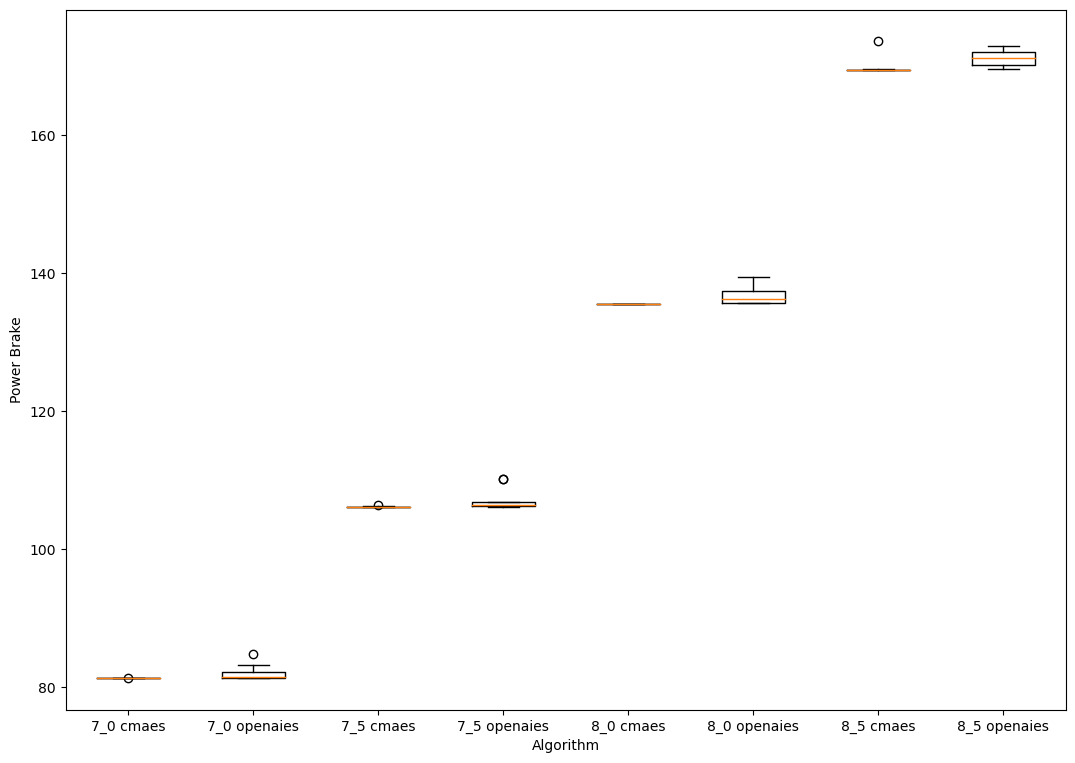

In [87]:
def get_fitness(results):
    return [-r.fitness for r in results]

data  = []
label = []
for vs in sorted(best_results_by_vs):
    for solver in sorted(best_results_by_vs[vs]):
        print(len(get_fitness(best_results_by_vs[vs][solver])))
        data.append(get_fitness(best_results_by_vs[vs][solver]))
        label.append(vs+' '+solver)


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xticklabels(label)


ax.set(
#     title='Comparison of the best results for minimal power brake',
    xlabel='Algorithm',
    ylabel='Power Brake',
)

# Creating plot
bp = ax.boxplot(data)

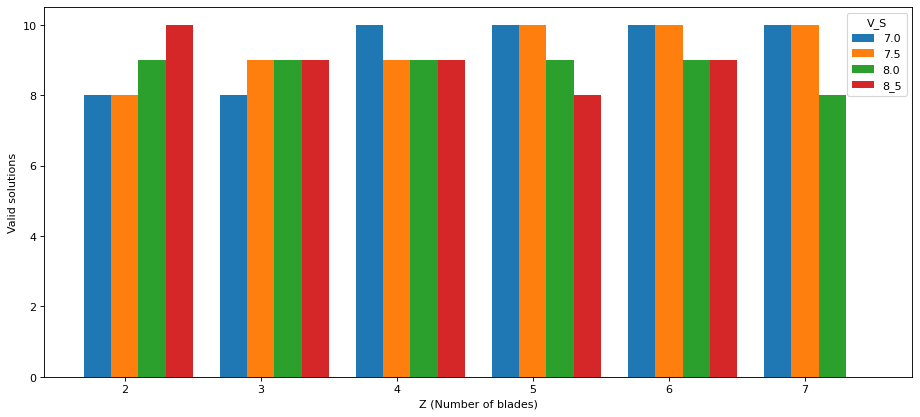

In [83]:
solver = 'cmaes' # you can change this

valids_by_z = {}
for vs in results_by_vs:
    # init valids dict
    valids_by_z[vs] = {}
    for z in range(2,8):
        valids_by_z[vs][z] = 0
    #
    for run in results_by_vs[vs][solver]:
        for z in run:
            if run[z].valid:
                valids_by_z[vs][z] += 1

# create data
x = np.arange(6)
vs = '7_0'
y1 = [valids_by_z[vs][z] for z in range(2,8)]
vs = '7_5'
y2 = [valids_by_z[vs][z] for z in range(2,8)]
vs = '8_0'
y3 = [valids_by_z[vs][z] for z in range(2,8)]
vs = '8_5'
y4 = [valids_by_z[vs][z] for z in range(2,8)]
width = 0.2
                
# plot data in grouped manner of bar type
plt.figure(figsize=(14,6), dpi=80)
plt.bar(x-width,   y1, width)
plt.bar(x,         y2, width)
plt.bar(x+width,   y3, width)
plt.bar(x+width*2, y4, width)
plt.xticks(x, [str(z) for z in range(2,8)])
plt.xlabel("Z (Number of blades)")
plt.ylabel("Valid solutions")
plt.legend(["7.0", "7.5", "8.0", "8_5"], title='V_S')
# plt.ylim(0,3000)
plt.show()


/tmp/ipykernel_3976/3518666662.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


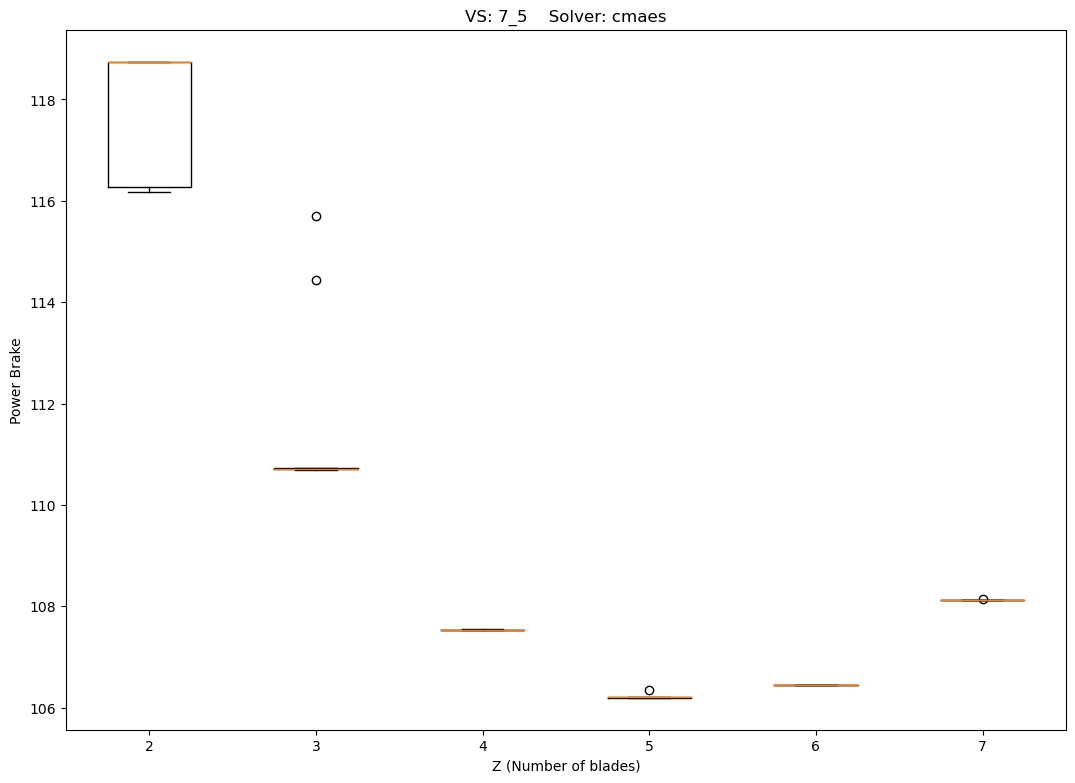

In [108]:
vs     = '7_5'   # you can change this
solver = 'cmaes' # you can change this

results_by_z = {}
# init valids dict
results_by_z[vs] = {}
for z in range(2,8):
    results_by_z[vs][z] = []
#
for run in results_by_vs[vs][solver]:
    for z in run:
        if run[z].valid:
            results_by_z[vs][z].append(-run[z].fitness)
        

data  = []
label = []
for z in range(2,8):
    data.append(results_by_z[vs][z])
    label.append(str(z))


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xticklabels(label)


ax.set(
    title ='VS: '+vs+'    Solver: '+solver,
    xlabel='Z (Number of blades)',
    ylabel='Power Brake',
)

# Creating plot
bp = ax.boxplot(data)

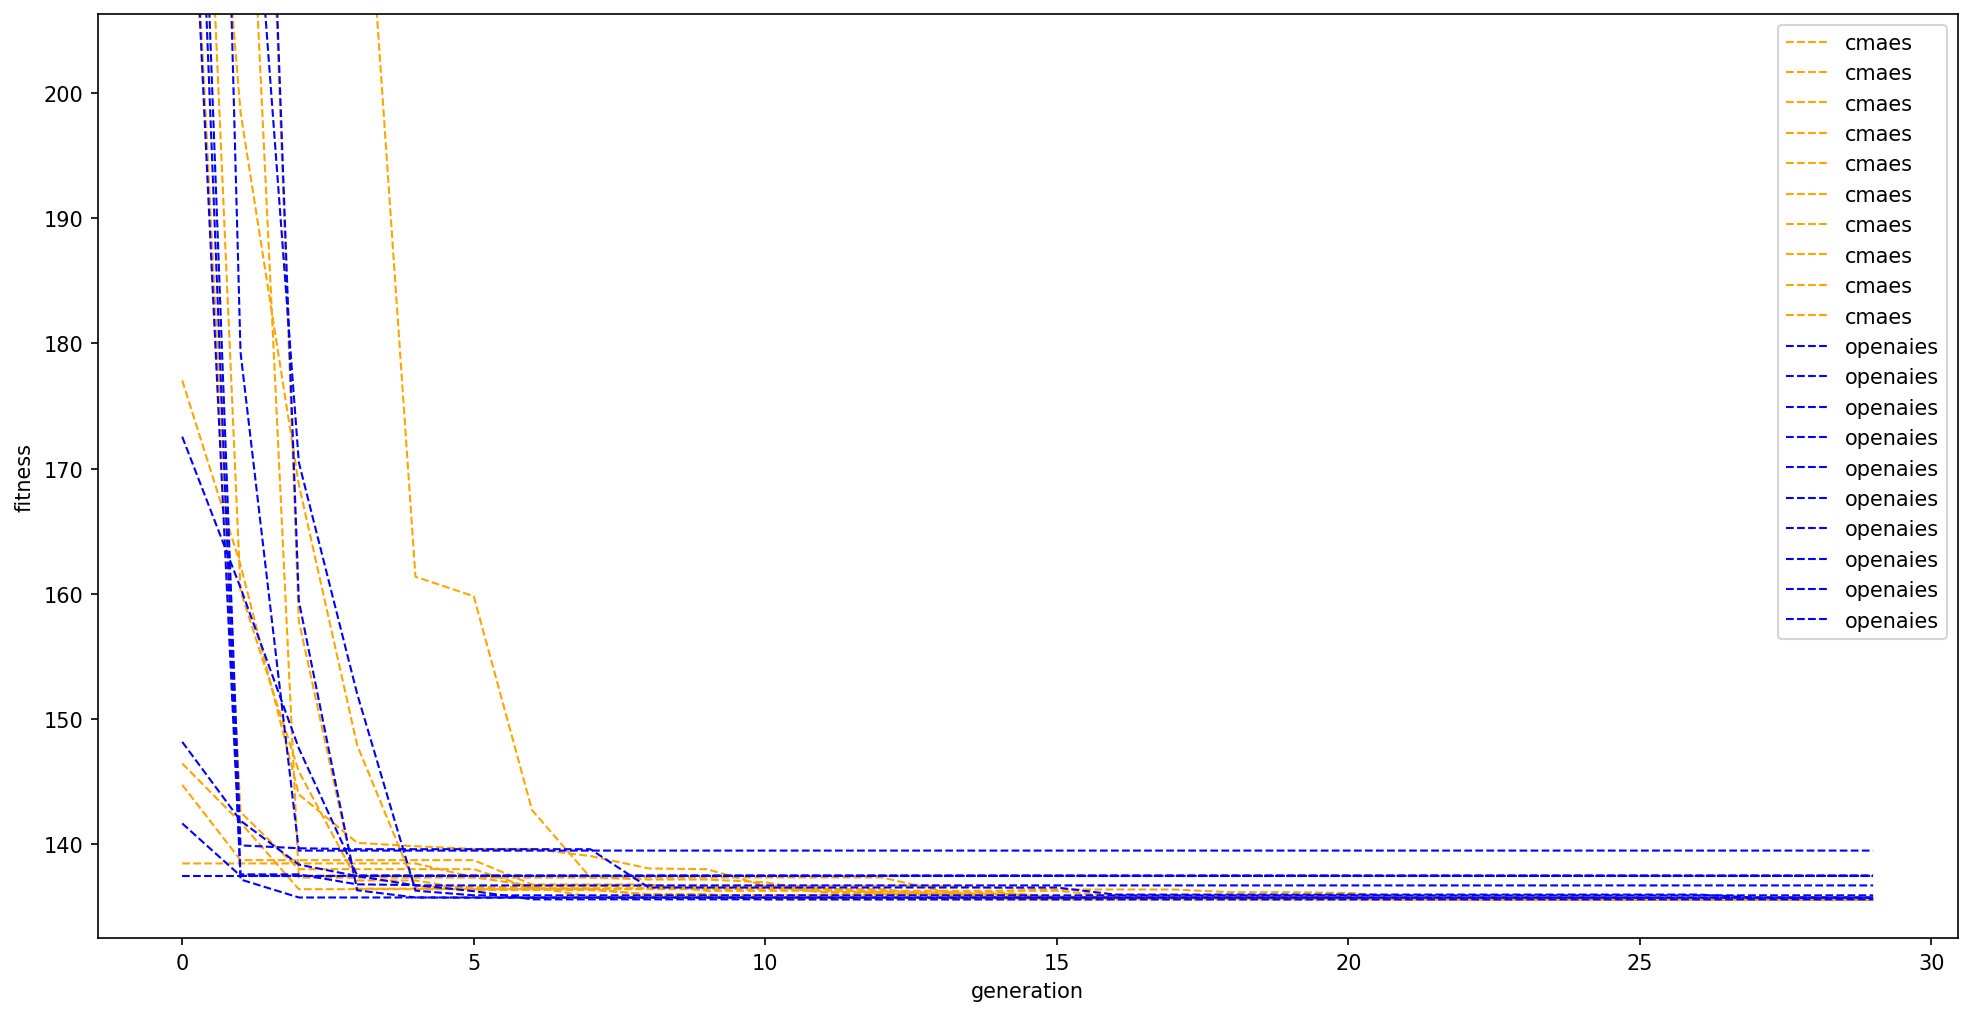

In [60]:
# Create a new figure
plt.figure(figsize=(16,8), dpi=150)
    
vs = '8_0'  # you can change this

bottom_lim = 0
lines = []
for solver in best_results_by_vs[vs]:
    color = solvers_colors[solver]
    label = solver
    linestyle='--'
    results = best_results_by_vs[vs][solver]
    bottom_lim = -results[0].fitness # just to crop the graph
    for r in results:
        history = r.history
        history = np.negative(history)
        line, = plt.plot(history, linewidth=1.0,linestyle=linestyle, color=color, label=label) 
        lines.append(line)
        
plt.legend(handles=lines)

plt.xlabel('generation')
plt.ylabel('fitness')

plt.ylim(bottom_lim-5, bottom_lim*1.5)
# 
plt.show()

In [49]:
# plt.figure(figsize=(16,8), dpi=150)

# lines = []
# for solver_name in solvers_results:
#     results     = solvers_results[solver_name]
#     best_result = max(results, key=lambda r: r[2])
#     color = solvers_colors[solver_name]
#     label = solver_name
#     history = best_result[3]
#     linestyle='-'
#     # if no history, print straight line
#     if len(history) < 2:
#         history = [best_result[2] for _ in range(history_size)]        
#         linestyle='--'
#     history = np.negative(history)
#     line, = plt.plot(history, linewidth=1.0,linestyle=linestyle, color=color, label=label) 
#     lines.append(line)

# plt.legend(handles=lines)
# plt.xlabel('generation')
# plt.ylabel('fitness')
# # 
# bot = min([solvers_best_fit[name] for name in solvers_results])
# top = max([solvers_best_fit[name] for name in solvers_results])
# plt.ylim(bot-0.1, top+0.1)

# plt.show()

In [50]:
# def show_label():
#     print('Algorithms without history:')
#     plt.figure(figsize=(3,3), dpi=150)
#     lines_fake_label = []
#     for solver_name in solvers_results:
#         results = solvers_results[solver_name]
#         color   = solvers_colors[solver_name]
#         label   = solver_name
        
#         # print the name of the algorithms without history
#         history = results[0][3]
#         if len(history) < 2:
#             print('-',label)
#         else:
#             line_fake, = plt.plot([1], linewidth=1.0, color=color, linestyle='--', label=label) 
#             lines_fake_label.append(line_fake)
#     plt.legend(handles=lines_fake_label)
#     plt.show()

In [51]:
# # Create a new figure
# plt.figure(figsize=(16,8), dpi=150)

# lines = []
# for solver_name in solvers_results:
#     results = solvers_results[solver_name]
#     color   = solvers_colors[solver_name]
#     label   = solver_name
#     for r in results:
#         history = r[3]
#         if len(history) > 1:
#             history = np.negative(history)
#             line, = plt.plot(history, linewidth=1.0, color=color, linestyle='--', label=label) 
#             lines.append(line)
        
# plt.xlabel('generation')
# plt.ylabel('fitness')
# # 
# plt.show()

# show_label()

In [52]:
# # Create a new figure
# plt.figure(figsize=(16,8), dpi=150)

# lines = []
# for solver_name in solvers_results:
#     results = solvers_results[solver_name]
#     color   = solvers_colors[solver_name]
#     label   = solver_name
#     for r in results:
#         history = r[3]
#         if len(history) > 1:
#             history = np.negative(history)
#             line, = plt.plot(history, linewidth=1.0, color=color, linestyle='--', label=label) 
#             lines.append(line)
        
# plt.xlabel('generation')
# plt.ylabel('fitness')

# plt.ylim(bot-0.1, top+0.1)
# # 
# plt.show()

# show_label()

In [54]:
# # result = [Z, (D, AEdAO, PdD), fitness, [history] ]
# best_results = []
# for solver_name in solvers_results:
#     results     = solvers_results[solver_name]
#     best_result = max(results, key=lambda r: r[2])
#     best_results.append([solver_name, best_result])

# # print best of all
# best_solver_name, best_result = min(best_results, key=lambda x: x[1]) 

# print('-- Best of all --')
# print(best_solver_name)

# Z             =  best_result[0]
# D, AEdAO, PdD =  best_result[1]
# P_B           = -best_result[2]

# print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
# print("P_B:",P_B)

In [55]:
# def show_img_for_Z(Z_):
#     # get the history of Z
#     z_history_openaies = [r[3] for r in results_openaies if r[0] == Z_][0]
#     z_history_cmaes    = [r[3] for r in results_cmaes    if r[0] == Z_][0]
#     # make fitness positive
#     z_history_openaies = np.negative(z_history_openaies)
#     z_history_cmaes    = np.negative(z_history_cmaes)

#     # Create a new figure
#     plt.figure(figsize=(16,8), dpi=150)

#     line_openaies, = plt.plot(z_history_openaies, linewidth=1.0, label=str(Z_)+' OPENAI-ES')
#     line_cmaes,    = plt.plot(z_history_cmaes,    linewidth=1.0, label=str(Z_)+' CMAES')  
    
#     plt.legend(handles=[line_openaies, line_cmaes])

#     plt.xlabel('generation')
#     plt.ylabel('fitness')

#     plt.show()
    
# # for z in range(range_Z[0], range_Z[1]+1):
# #     show_img_for_Z(z)

In [56]:
# # best value for Z, in all runs
# data = [solvers_results[name] for name in solvers_results]

# big_zs = np.ones(8)
# big_zs *= float('inf')
# for r_solver in data:
#     zs = np.ones(8)
#     zs *= float('inf')
#     for r in r_solver:
#         z = r[0]
#         fit = -r[2]
#         zs[z] = min(zs[z], fit)
#     for z in range(8):
#         big_zs[z] = min(zs[z], big_zs[z])
        
# # print Z and best fitness, if found a fitness for that Z
# for z in range(8):
#     if big_zs[z] != 0 and big_zs[z] != float('inf'):
#         print('Z:',z, 'fit:',big_zs[z])